# Data scientist challenge - LATAM Airlines

## TABLA DE CONTENIDOS:

* [1 - PREPROCESAMIENTO DE DATOS](#prep)
    * [1.1 - IMPORTACIÓN DE MÓDULOS](#package)
    * [1.2 - IMPORTACIÓN DE BASE DE DATOS](#import)
    * [1.3 - ANÁLISIS EXPLORATORIO](#exp)
    * [1.4 - SYNTHETIC FEATURES](#synt)
    * [1.5 - ANÁLISIS DESCRIPTIVO](#desc)
    * [1.6 - ANÁLISIS DE AUTOCORRELACIÓN](#corr)
    * [1.7 - DEFINICIÓN DE DATA DE ENTRENAMIENTO Y TEST](#split)
    * [1.8 - BALANCEO DE DUMMIE ATRASO](#bal)
    
* [2 - MODELAMIENTO DE DATOS](#model)
    * [2.1 - MODELO 1: LOGIT](#glm)
    * [2.2 - MODELO 2: RANDOM FOREST](#random)
    * [2.3 - MODELO 3: REDES NEURONALES](#neural)
* [3 - CONCLUSIONES](#conc)

## 1 - PREPROCESAMIENTO DE DATOS <a class="anchor" id="prep"></a>

### 1.1 - IMPORTACIÓN DE MÓDULOS <a class="anchor" id="package"></a>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

### 1.2 - IMPORTACIÓN DE BASE DE DATOS <a class="anchor" id="import"></a>

In [2]:
df = pd.read_csv(r'..\data\dataset_SCL.csv', low_memory=False)
# Formato datetime
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'], format='%Y-%m-%d %H:%M:%S')

### 1.3 - ANÁLISIS EXPLORATORIO <a class="anchor" id="exp"></a>

In [3]:
# Porcentaje de nan
round(df.isna().sum()/len(df)*100,2)

Fecha-I      0.0
Vlo-I        0.0
Ori-I        0.0
Des-I        0.0
Emp-I        0.0
Fecha-O      0.0
Vlo-O        0.0
Ori-O        0.0
Des-O        0.0
Emp-O        0.0
DIA          0.0
MES          0.0
AÑO          0.0
DIANOM       0.0
TIPOVUELO    0.0
OPERA        0.0
SIGLAORI     0.0
SIGLADES     0.0
dtype: float64

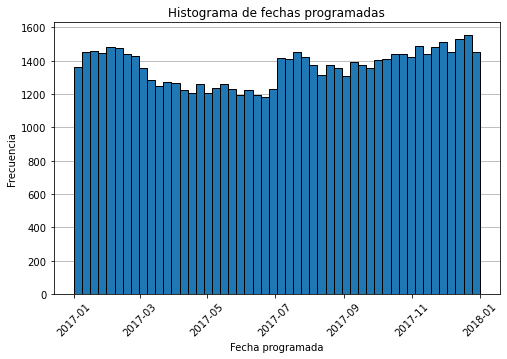

In [4]:
# Distribución de fecha programada de vuelo
fig, ax = plt.subplots(figsize=(8,5)) 
plt.hist(df['Fecha-I'], edgecolor='black', bins=50)
ax.set_xlabel('Fecha programada')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de fechas programadas')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='y')

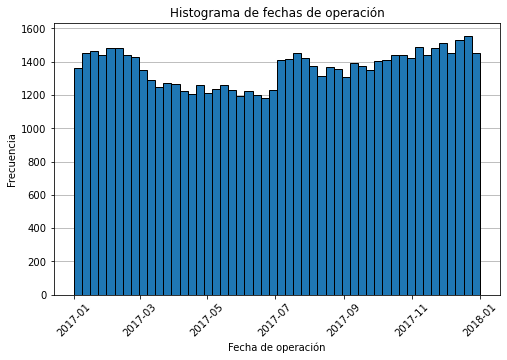

In [5]:
# Distribución de fecha de operación de vuelo
fig, ax = plt.subplots(figsize=(8,5)) 
plt.hist(df['Fecha-O'], edgecolor='black', bins=50)
ax.set_xlabel('Fecha de operación')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de fechas de operación')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='y')

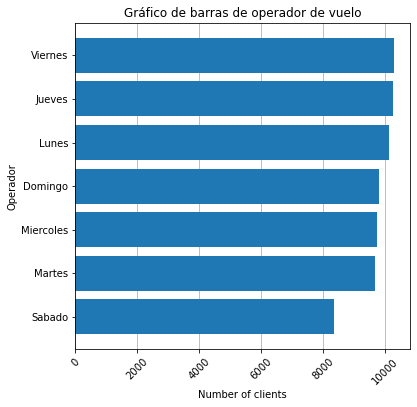

In [6]:
# Distribución de día de la semana de operación de vuelo
fig, ax = plt.subplots(figsize=(6,6)) 
plt.barh(df['DIANOM'].value_counts().index, df['DIANOM'].value_counts())
plt.title('Gráfico de barras de operador de vuelo')
plt.ylabel('Operador')
plt.xlabel('Number of clients')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

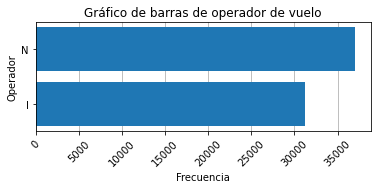

In [7]:
# Distribución de tipo de vuelo
fig, ax = plt.subplots(figsize=(6,2)) 
plt.barh(df['TIPOVUELO'].value_counts().index, df['TIPOVUELO'].value_counts())
plt.title('Gráfico de barras de operador de vuelo')
plt.ylabel('Operador')
plt.xlabel('Frecuencia')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

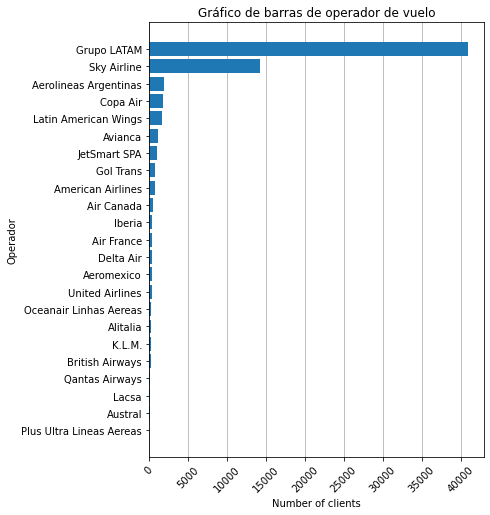

In [8]:
# Distribución de operador de vuelo
fig, ax = plt.subplots(figsize=(6,8)) 
plt.barh(df['OPERA'].value_counts().index, df['OPERA'].value_counts())
plt.title('Gráfico de barras de operador de vuelo')
plt.ylabel('Operador')
plt.xlabel('Number of clients')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

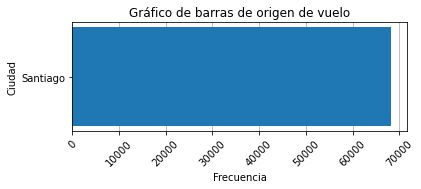

In [9]:
# Distribución de origen
fig, ax = plt.subplots(figsize=(6,2)) 
plt.barh(df['SIGLAORI'].value_counts().index, df['SIGLAORI'].value_counts())
plt.title('Gráfico de barras de origen de vuelo')
plt.ylabel('Ciudad')
plt.xlabel('Frecuencia')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

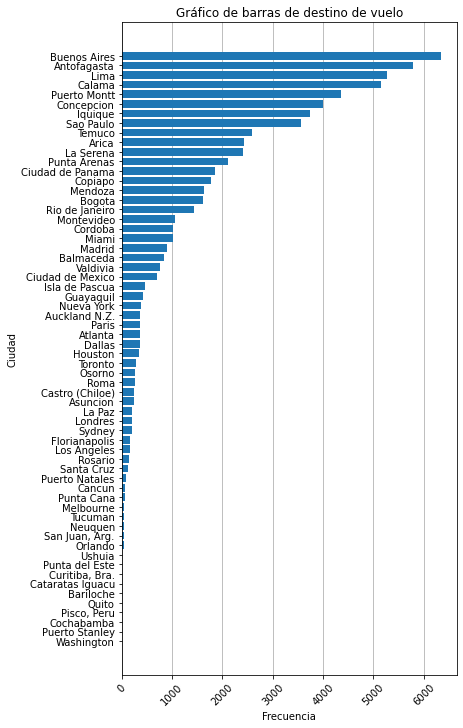

In [10]:
# Distribución de destino
fig, ax = plt.subplots(figsize=(6,12)) 
plt.barh(df['SIGLADES'].value_counts().index, df['SIGLADES'].value_counts())
plt.title('Gráfico de barras de destino de vuelo')
plt.ylabel('Ciudad')
plt.xlabel('Frecuencia')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

##### Podemos observar que la distribución de los datos es bastante homogenea en las fechas programadas y de operación de los vuelos, en el día de la semana de operación (salvo una leve baja el día sábado) y en el tipo de vuelo. No así para las variables de aerolíneas (en su mayoría de grupo LATAM), en la ciudad de origen (en su totalidad de Santiago) y la ciudad de destino.

##### Podemos concluir que la data es bastante completa (no contiene datos vacíos) y bastante representativa temporalmente (homogenea y de un año completo). Por otro lado, no es tan homogenea a nivel de aerolíneas y de ciudad de origen y de destino, lo cual podría generar una poca representatividad  en el análisis para estas variables.

### 1.4 - SYNTHETIC FEATURES <a class="anchor" id="synt"></a>

In [11]:
# Temporada alta
df['temporada_alta'] = [1 if (x < dt.datetime(2017,3,4)) or (x >= dt.datetime(2017,12,15)) or ((x >= dt.datetime(2017,7,15)) and (x < dt.datetime(2017,8,1))) or ((x >= dt.datetime(2017,9,11)) and (x < dt.datetime(2017,10,1))) else 0 for x in df['Fecha-I']]

In [12]:
# Diferencia en minutos
df['dif_min'] = (df['Fecha-O']-df['Fecha-I'])/pd.Timedelta(minutes=1)

In [13]:
# Atraso de 15 minutos
df['atraso_15'] = [1 if x>15 else 0 for x in df['dif_min']]

In [14]:
# Período del día
df['periodo_dia'] = ['mañana' if (x.time() >= dt.time(5,0)) and (x.time() < dt.time(12,0)) else 'tarde' if (x.time() >= dt.time(12,0)) and (x.time() < dt.time(19,0)) else 'noche' for x in df['Fecha-I']]

In [15]:
# Cambio de destino
df['dif_destino'] = (df['Des-I']!=df['Des-O'])*1

In [16]:
# Exportación de datos
df[['temporada_alta','dif_min','atraso_15','periodo_dia','dif_destino']].to_csv(r'..\data\synthetic_features.csv', index=False)

### 1.5 - ANÁLISIS DESCRIPTIVO <a class="anchor" id="desc"></a>

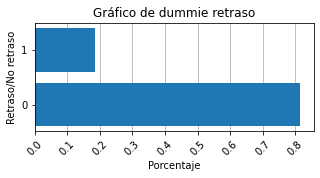

In [17]:
# Tasa de atraso
fig, ax = plt.subplots(figsize=(5,2)) 
plt.barh(['1','0'], [df['atraso_15'].mean(), 1-df['atraso_15'].mean()])
plt.title('Gráfico de dummie retraso')
plt.ylabel('Retraso/No retraso')
plt.xlabel('Porcentaje')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

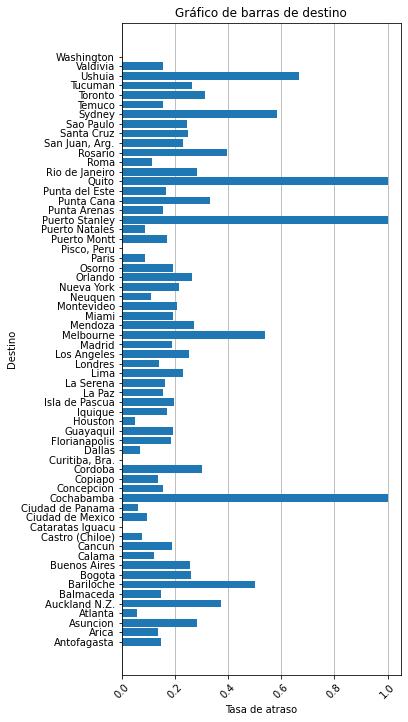

In [18]:
# Tasa de atraso por destino
fig, ax = plt.subplots(figsize=(5,12)) 
plt.barh(df.groupby('SIGLADES').agg('mean')['atraso_15'].reset_index()['SIGLADES'], df.groupby('SIGLADES').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de destino')
plt.ylabel('Destino')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')

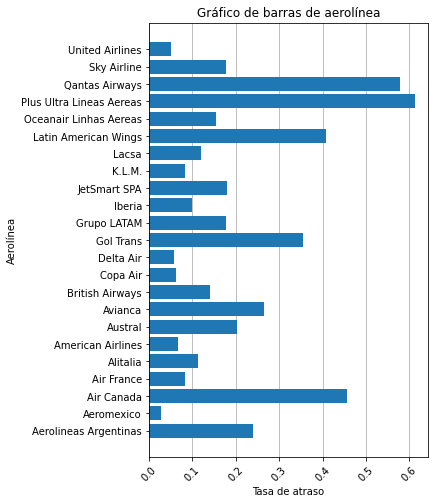

In [19]:
# Tasa de atraso por aerolínea
fig, ax = plt.subplots(figsize=(5,8)) 
plt.barh(df.groupby('OPERA').agg('mean')['atraso_15'].reset_index()['OPERA'], df.groupby('OPERA').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de aerolínea')
plt.ylabel('Aerolínea')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')

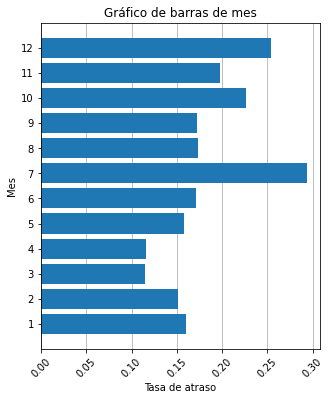

In [20]:
# Tasa de atraso por mes
fig, ax = plt.subplots(figsize=(5,6)) 
plt.barh(df.groupby('MES').agg('mean')['atraso_15'].reset_index()['MES'].astype(str), df.groupby('MES').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de mes')
plt.ylabel('Mes')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')

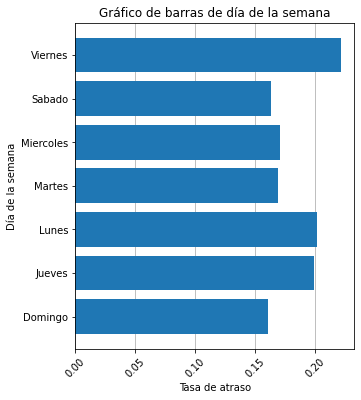

In [21]:
# Tasa de atraso por día de la semana
fig, ax = plt.subplots(figsize=(5,6)) 
plt.barh(df.groupby('DIANOM').agg('mean')['atraso_15'].reset_index()['DIANOM'], df.groupby('DIANOM').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de día de la semana')
plt.ylabel('Día de la semana')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')

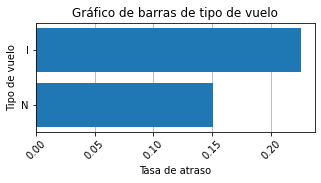

In [22]:
# Tasa de atraso por tipo de vuelo
fig, ax = plt.subplots(figsize=(5,2)) 
plt.barh(df.groupby('TIPOVUELO').agg('mean')['atraso_15'].reset_index()['TIPOVUELO'], df.groupby('TIPOVUELO').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de tipo de vuelo')
plt.ylabel('Tipo de vuelo')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

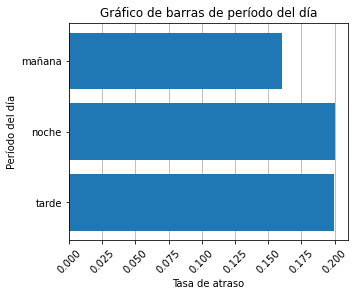

In [23]:
# Tasa de atraso por período del día
fig, ax = plt.subplots(figsize=(5,4)) 
plt.barh(df.groupby('periodo_dia').agg('mean')['atraso_15'].reset_index()['periodo_dia'], df.groupby('periodo_dia').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de período del día')
plt.ylabel('Período del día')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

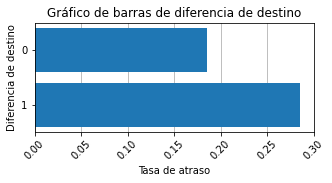

In [24]:
# Tasa de atraso por diferencia de destino
fig, ax = plt.subplots(figsize=(5,2)) 
plt.barh(df.groupby('dif_destino').agg('mean')['atraso_15'].reset_index()['dif_destino'].astype(str), df.groupby('dif_destino').agg('mean')['atraso_15'].reset_index()['atraso_15'])
plt.title('Gráfico de barras de diferencia de destino')
plt.ylabel('Diferencia de destino')
plt.xlabel('Tasa de atraso')
plt.xticks(rotation=45)
ax.set_axisbelow(True)
plt.grid(axis='x')
plt.gca().invert_yaxis()

##### Podemos observar que la distribución de la tasa de atraso es bastante homogenea con respecto al día de la semana, tipo de vuelo, período del día y a la diferencia de destino. No así con respecto al destino, la aerolínea y el mes del vuelo.

##### Podemos concluir que las variables con mayor varianza con respecto a la tasa de atraso (destino, aerolínea y el mes de vuelo) debieen ser las variables con mayor poder predictivo de la probabilidad de atraso del vuelo.

### 1.6 - ANÁLISIS DE AUTOCORRELACIÓN <a class="anchor" id="corr"></a>

In [25]:
# Filtro de variables
df = df[['DIANOM','MES','TIPOVUELO','OPERA','SIGLADES','temporada_alta','periodo_dia','dif_destino','atraso_15']]
df['MES'] = df['MES'].astype(str)

In [26]:
# Generación de variables dummies
df = pd.get_dummies(df, drop_first=True)
# Reorden de columnas
cols = df.columns.tolist()
cols.pop(cols.index('atraso_15'))
cols = cols+['atraso_15']
df.columns = cols

In [27]:
# Matriz de correlación
corr_matrix = df.drop(columns='atraso_15').corr().abs()

In [28]:
# Selección de triángulo superior
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

In [29]:
# Variables con correlación > 0.95
to_drop = [column for column in lower.columns if any(lower[column]>0.95)]

In [30]:
# Drop variables
df = df.drop(columns=to_drop)

### 1.7 - DEFINICIÓN DE DATA DE ENTRENAMIENTO Y TEST <a class="anchor" id="split"></a>

In [31]:
# Split de data
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=2)

### 1.8 - BALANCEO DE DUMMIE 'ATRASO'<a class="anchor" id="bal"></a>

In [32]:
# Balanceo
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [33]:
# Inclusión de constante
X_train_cons = sm.add_constant(X_train)
X_test_cons = sm.add_constant(X_test)

## 2 - MODELAMIENTO DE DATOS <a class="anchor" id="model"></a>

### 2.1 MODELO 1: LOGIT <a class="anchor" id="glm"></a>

In [34]:
# Columnas de análisis
#cols = df.columns.values.tolist()
#y = ['atraso_15']
#X = [x for x in cols if x not in y]
# Feature Selection
#logreg = LogisticRegression()
#rfe = RFE(estimator=logreg, n_features_to_select=35).fit(X_train, y_train)
# Features
#L_cols = [X[i] for i in range(len(X)) if rfe.support_[i]==True]

In [54]:
# Entrenamiento de modelo logit
L_model = LogisticRegression().fit(X_train, y_train)

C:\Users\EY538CS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# Predicción de data test
L_y_pred = L_model.predict(X_test)

In [63]:
# Performance de modelo lineal
print('Accuracy: %.3f' % accuracy_score(y_test, L_y_pred))
print('Precision: %.3f' % precision_score(y_test, L_y_pred))
print('Recall: %.3f' % recall_score(y_test, L_y_pred))

Accuracy: 0.692
Precision: 0.559
Recall: 0.899


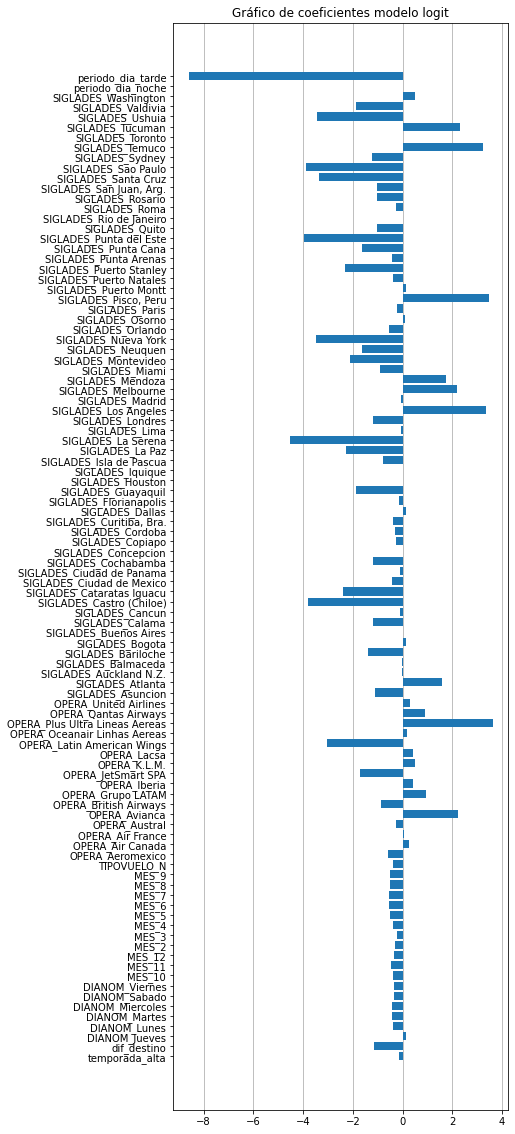

In [70]:
# Plot de coeficientes
fig, ax = plt.subplots(figsize=(6,20))
plt.barh(L_model.feature_names_in_, L_model.coef_[0])
plt.title('Gráfico de coeficientes modelo logit')
plt.grid(axis='x')
ax.set_axisbelow(True)